In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import resources
from pathlib import PurePosixPath as Path
import time

from keras.layers import Input, Dropout, BatchNormalization
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.models import Sequential, Model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/tomje/miniconda3/envs/tf/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load RMS signals for autoencoder

In [2]:
exp = 'Test 5'
rms = resources.ae.RMS(exp)
rms.data.drop(['0', '1', '2'], axis=1, inplace=True)
rms._data = rms.data.T.reset_index(drop=True).T

--------------------------------------------------
Loaded RMS data for "22_08_03_grit1000"
Experiemnt No: Test 5
Number of files: 213
--------------------------------------------------


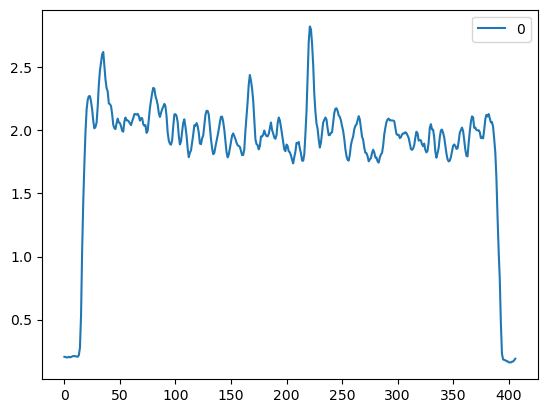

In [3]:
rms.data.plot(y=0);

Remove DC component from RMS signal and section to only between trigger points

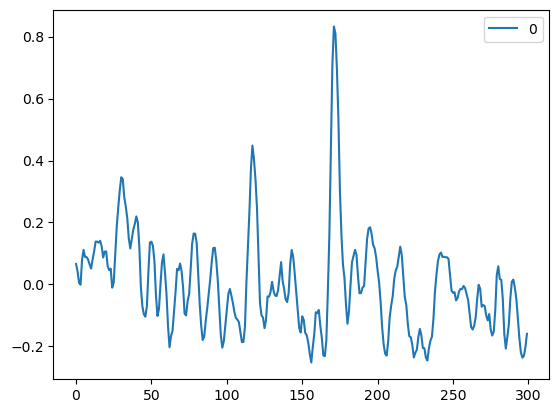

In [4]:
def remove_dc(sig):
    return sig - np.nanmean(sig)

rms._data = rms.data.iloc[50:350, :].reset_index(drop=True)
rms._data = rms.data.apply(remove_dc, axis=0)
rms.data.plot(y=0);

In [5]:
full_rms = []
np.shape(rms.data)
for i in range(np.shape(rms.data)[1]):
    full_rms.extend(rms.data.iloc[:, i].values.T)
full_rms = np.array(full_rms).reshape(-1, 1)
print(f'Number of RMS samples: {np.shape(full_rms)}')

Number of RMS samples: (63000, 1)


In [6]:
np.isnan(full_rms).any()

False

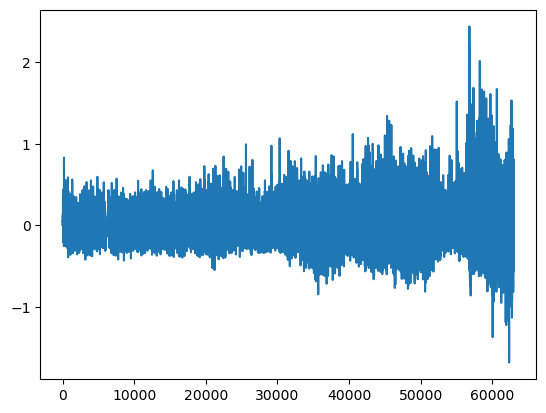

In [7]:
plt.plot(full_rms);

## Create sequences for autoencoder

In [8]:
SEQ_LEN = 100

def to_sequences(data, seq_len=SEQ_LEN):
    d = []
    for index in range(len(data) - seq_len + 1):
        d.append(data[index: (index + seq_len)])
    return np.stack(d)

x_train = to_sequences(full_rms, SEQ_LEN)
print(f'Training input shape: {x_train.shape}')

Training input shape: (62901, 100, 1)


## Split data and scale

In [9]:
NO_TRAIN_SIGS = 60
x_test = x_train[(NO_TRAIN_SIGS*300):]
x_train = x_train[:(NO_TRAIN_SIGS*300)]
print(f'Training input shape: {x_train.shape}')
print(f'Test input shape: {x_test.shape}')

Training input shape: (18000, 100, 1)
Test input shape: (44901, 100, 1)


In [10]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train.reshape(-1, 1)).reshape(-1, SEQ_LEN, 1)
x_test = scaler.transform(x_test.reshape(-1, 1)).reshape(-1, SEQ_LEN, 1)

## Create Autoencoder

In [11]:
platform = os.name
if platform == 'nt':
    onedrive = Path(r'C:\Users\tomje\OneDrive - Cardiff University')
    onedrive = onedrive.joinpath('Documents', 'PHD', 'AE')
    TB_DIR= onedrive.joinpath('Tensorboard')
elif platform == 'posix':
    onedrive = Path(r'/mnt/c/Users/tomje/OneDrive - Cardiff University')
    onedrive = onedrive.joinpath('Documents', 'PHD', 'AE')
    TB_DIR= onedrive.joinpath('Tensorboard')
print(TB_DIR)

/mnt/c/Users/tomje/OneDrive - Cardiff University/Documents/PHD/AE/Tensorboard


In [12]:
N_SIZE = [256, 128, 64]
N_BOTTLENECK = 32
N_FEATURES = x_train.shape[2]

# autoe = Sequential()

# autoe.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
# autoe.add(LSTM(256, return_sequences=True))
# autoe.add(Dropout(0.1))
# autoe.add(LSTM(128, return_sequences=True))
# autoe.add(Dropout(0.1))
# autoe.add(LSTM(64, return_sequences=True))
# autoe.add(Dropout(0.1))
# autoe.add(LSTM(32, return_sequences=False))
# autoe.add(Dropout(0.1))

# autoe.add(RepeatVector(x_train.shape[1]))
# autoe.add(LSTM(32, return_sequences=True))
# autoe.add(Dropout(0.1))
# autoe.add(LSTM(64, return_sequences=True))
# autoe.add(Dropout(0.1))
# autoe.add(LSTM(128, return_sequences=True))
# autoe.add(Dropout(0.1))
# autoe.add(LSTM(256, return_sequences=True))
# autoe.add(Dropout(0.1))
# autoe.add(TimeDistributed(Dense(x_train.shape[2])))


def get_encoder(seq_len, n_features, n_bottleneck, n_size):
    encoder_in = Input(shape=(seq_len, n_features))
    e = encoder_in

    for dim in n_size:
        e = LSTM(dim, return_sequences=True)(e)
        e = Dropout(0.1)(e)
        e = BatchNormalization()(e)
    
    encoder_out = LSTM(n_bottleneck, return_sequences=False)(e)
    encoder = Model(encoder_in, encoder_out, name='Encoder')
    return encoder

def get_decoder(seq_len, n_features, n_bottleneck, n_size):
    decoder_in = Input(shape=(n_bottleneck,))
    d = RepeatVector(seq_len)(decoder_in)

    for dim in n_size[::-1]:
        d = LSTM(dim, return_sequences=True)(d)
        d = Dropout(0.1)(d)
        d = BatchNormalization()(d)
    
    decoder_out = TimeDistributed(Dense(n_features))(d)
    decoder = Model(decoder_in, decoder_out, name='Decoder')
    return decoder

encoder = get_encoder(SEQ_LEN, N_FEATURES, N_BOTTLENECK, N_SIZE)
decoder = get_decoder(SEQ_LEN, N_FEATURES, N_BOTTLENECK, N_SIZE)

autoencoder_in = Input(shape=(SEQ_LEN, 1), name='Input')
encoded = encoder(autoencoder_in)
decoded = decoder(encoded)
autoe = Model(autoencoder_in, decoded, name='Autoencoder')

optimiser = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False, clipnorm=1., clipvalue=0.5)
autoe.compile(optimizer=optimiser, loss='mean_squared_error')
autoe.summary()

layers = N_SIZE + [N_BOTTLENECK] + N_SIZE[::-1]
T = time.strftime("%Y%m%d-%H%M%S", time.localtime())

run_name = f'LSTMAE-{exp}-WIN-{SEQ_LEN}-L-{layers}-T-{T}'

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 100, 1)]          0         
                                                                 
 Encoder (Functional)        (None, 32)                524928    
                                                                 
 Decoder (Functional)        (None, 100, 1)            519937    
                                                                 
Total params: 1,044,865
Trainable params: 1,043,073
Non-trainable params: 1,792
_________________________________________________________________


In [13]:
# add model checkpoint callback
model_folder = TB_DIR.joinpath('AUTOE', run_name)
if not os.path.exists(model_folder):
    os.makedirs(model_folder)
assert os.path.exists(model_folder)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min'
        ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_folder.joinpath(f'{run_name}.h5'),
        monitor='val_loss', 
        mode='min',
        save_best_only=True,
        save_weights_only=False,
        )
]

In [14]:
# train model
history = autoe.fit(
    x_train, x_train,
    validation_split=0.33,
    # validation_data=(x_test, x_test),
    epochs=500,
    batch_size=64,
    use_multiprocessing=True,
    callbacks=callbacks,
)

Epoch 1/500
189/189 [==============================] - 161s 793ms/step - loss: 0.2157 - val_loss: 0.0159
Epoch 2/500
189/189 [==============================] - 146s 775ms/step - loss: 0.0489 - val_loss: 0.0141
Epoch 3/500
189/189 [==============================] - 147s 776ms/step - loss: 0.0204 - val_loss: 0.0125
Epoch 4/500
189/189 [==============================] - 147s 779ms/step - loss: 0.0129 - val_loss: 0.0118
Epoch 5/500
189/189 [==============================] - 147s 777ms/step - loss: 0.0107 - val_loss: 0.0121
Epoch 6/500
189/189 [==============================] - 147s 780ms/step - loss: 0.0100 - val_loss: 0.0117
Epoch 7/500
189/189 [==============================] - 148s 784ms/step - loss: 0.0096 - val_loss: 0.0116
Epoch 8/500
189/189 [==============================] - 147s 777ms/step - loss: 0.0093 - val_loss: 0.0152
Epoch 9/500
189/189 [==============================] - 145s 767ms/step - loss: 0.0090 - val_loss: 0.0112
Epoch 10/500
189/189 [==============================] -

In [15]:
# reload best model
autoe = tf.keras.saving.load_model(model_folder.joinpath(f'{run_name}.h5'))

[autoreload of scikeras.wrappers failed: Traceback (most recent call last):
  File "/home/tomje/miniconda3/envs/tf/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/tomje/miniconda3/envs/tf/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/home/tomje/miniconda3/envs/tf/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/tomje/miniconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py", line 1579, in <module>
    class KerasRegressor(BaseWrapper, RegressorMixin):
  File "/home/tomje/miniconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.p

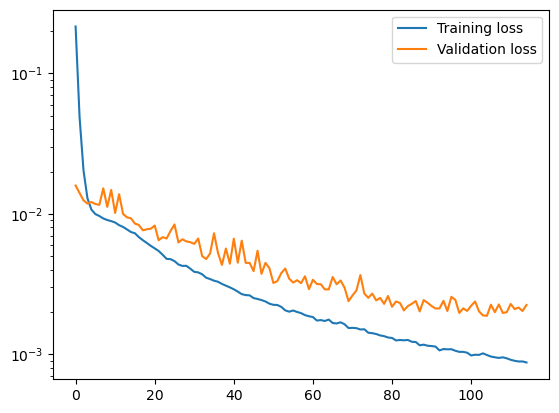

In [16]:
# plot training loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.yscale('log')
plt.legend();

In [17]:
# rn = TB_DIR.joinpath('AUTOE', 'LSTMAE-Test 8-WIN-100-L-[256, 128, 64, 32, 16, 32, 64, 128, 256]-T-20230719-104249', 'LSTMAE-Test 8-WIN-100-L-[256, 128, 64, 32, 16, 32, 64, 128, 256]-T-20230719-104249.h5')
# print(os.path.exists(rn))
# autoe = tf.keras.saving.load_model(rn)

563/563 [==============================] - 112s 195ms/step


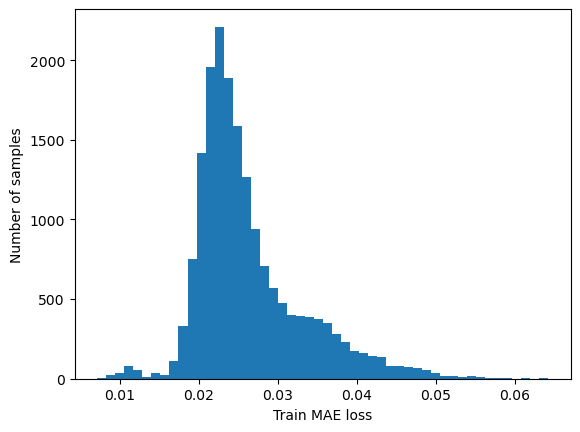

In [18]:
x_train_pred = autoe.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50);
plt.xlabel('Train MAE loss')
plt.ylabel('Number of samples');

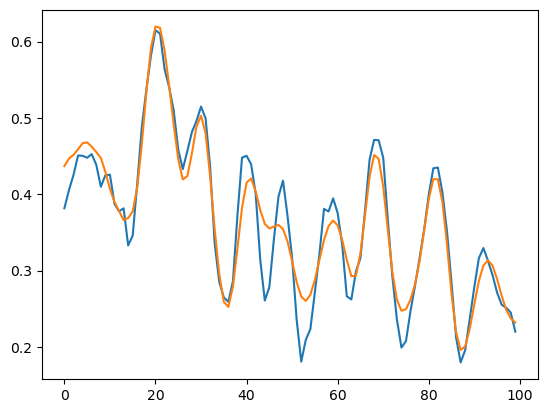

In [19]:
i = 10
plt.plot(x_train[i])
plt.plot(x_train_pred[i])

1404/1404 [==============================] - 272s 194ms/step


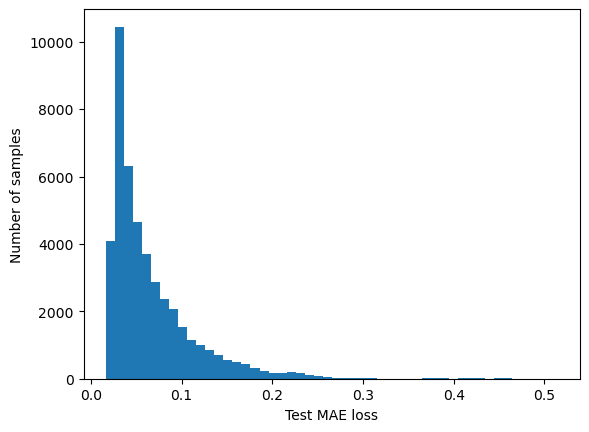

In [20]:
# Test data
x_test_pred = autoe.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

plt.hist(test_mae_loss, bins=50);
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

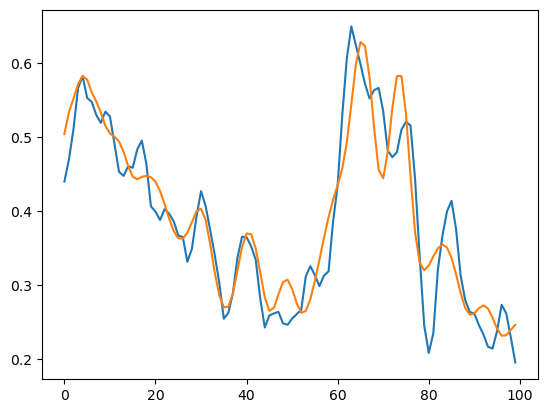

In [21]:
plt.plot(x_test[i])
plt.plot(x_test_pred[i])

In [22]:
print(f'No of train errors: {len(train_mae_loss)}')
print(f'No of test errors: {len(test_mae_loss)}\n')

# Threshold
THRESHOLD = np.percentile(train_mae_loss, 97)
print(f'Reconstruction error threshold: {THRESHOLD:3f}')


anomalies = np.concatenate([train_mae_loss, test_mae_loss], axis=0) > THRESHOLD
print(f'Number of anomaly samples: {np.sum(anomalies)}')

No of train errors: 18000
No of test errors: 44901

Reconstruction error threshold: 0.043250
Number of anomaly samples: 26376


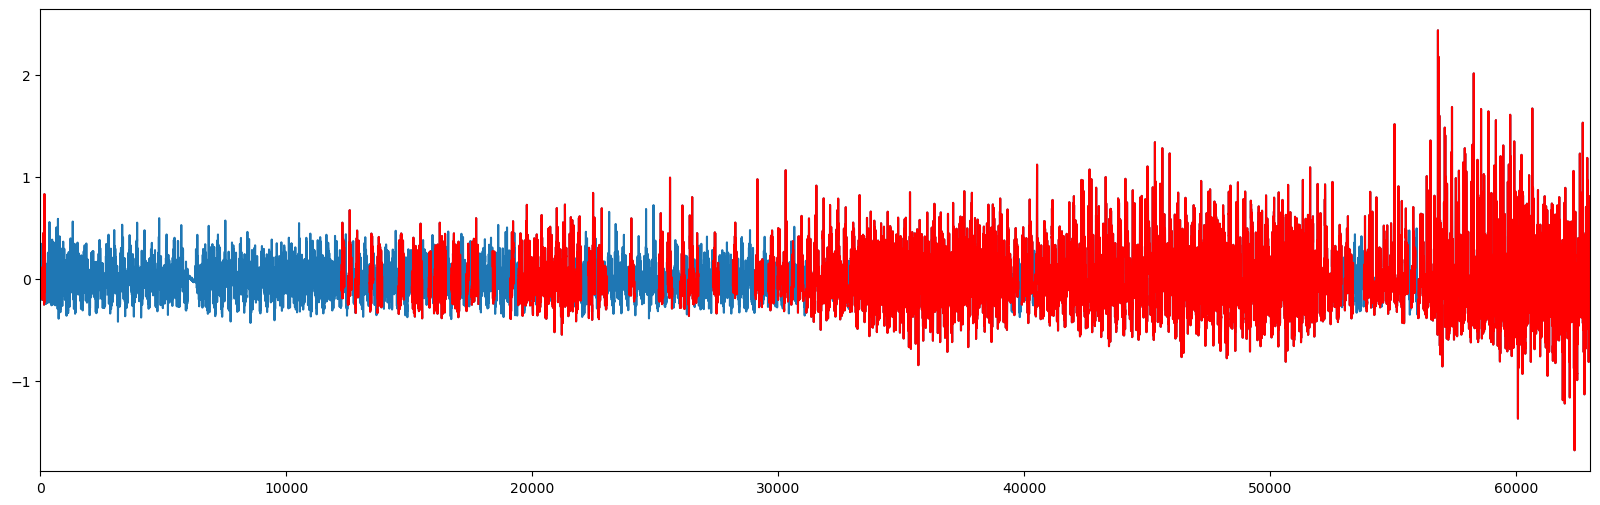

In [23]:
anomalous_data_indices = [False] * len(full_rms)
np.array(anomalous_data_indices)
for i, anom in enumerate(anomalies):
    if anom:
        for j in range(i, (i + SEQ_LEN - 1)):
            anomalous_data_indices[j] = True

df_full_rms = pd.DataFrame(full_rms)
df_anom = df_full_rms.copy()
df_anom.loc[np.invert(anomalous_data_indices)] = np.nan

fig, ax = plt.subplots(figsize=(20, 6))
df_full_rms.plot(legend=False, ax=ax)
df_anom.plot(legend=False, ax=ax, color="r")
plt.autoscale(enable=True, axis='x', tight=True)

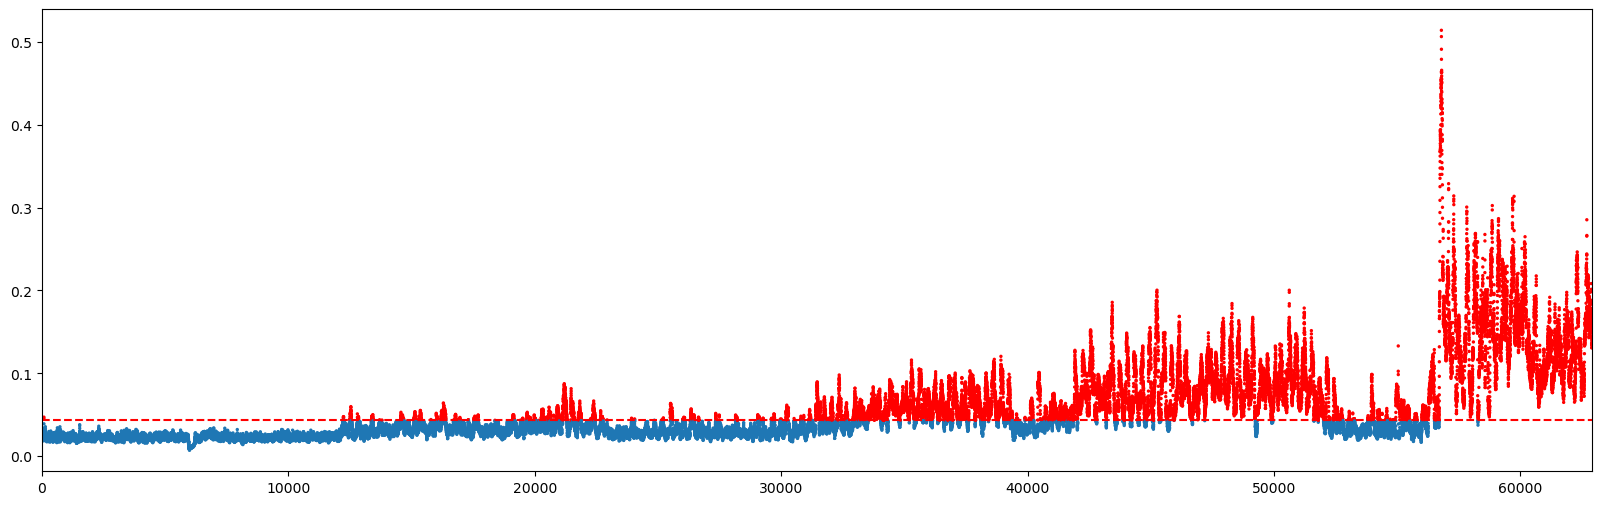

In [24]:
mae = np.concatenate([train_mae_loss, test_mae_loss], axis=0)

cmap = []
for m in mae:
    if m > THRESHOLD:
        cmap.append('r')
    else:
        cmap.append('C0')

fig, ax = plt.subplots(figsize=(20, 6))
plt.scatter(x=range(len(mae)), y=mae, c=cmap, s=2)
ax.axhline(y=THRESHOLD, color='r', linestyle='--')
plt.autoscale(enable=True, axis='x', tight=True)

In [25]:
exp_data = resources.load(exp)

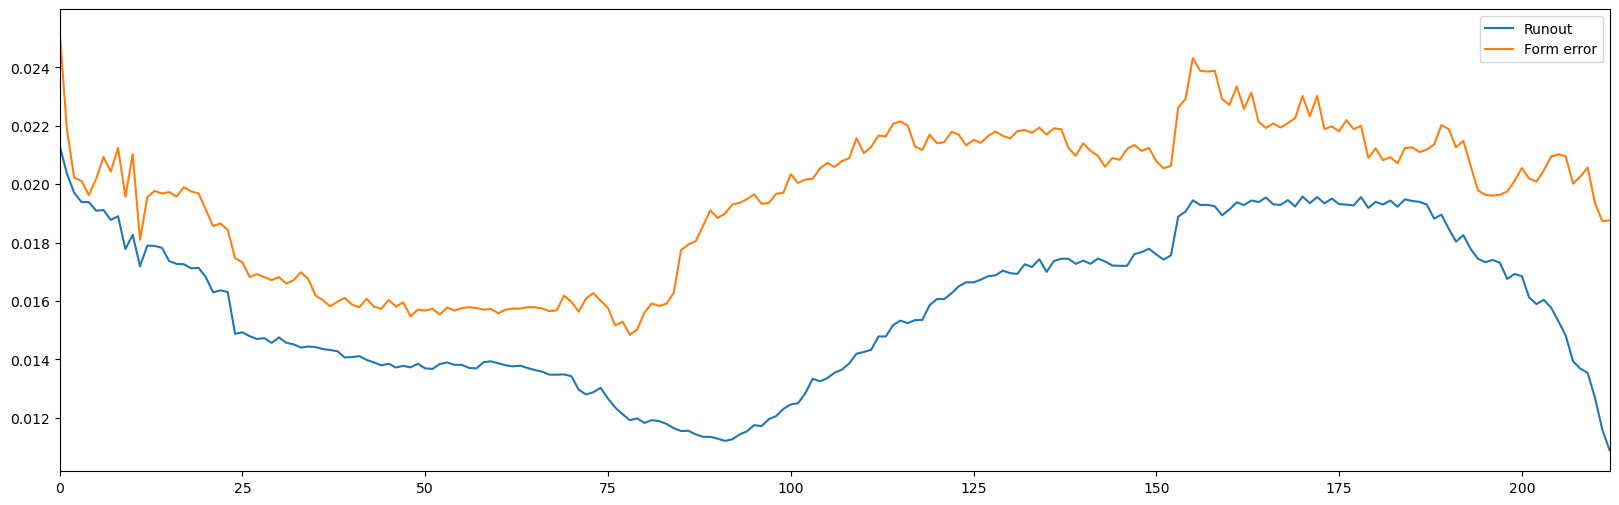

In [26]:
fig, ax = plt.subplots(figsize=(20, 6))
exp_data.features.plot(y=['Runout', 'Form error'], ax=ax)
plt.autoscale(enable=True, axis='x', tight=True)